<a href="https://colab.research.google.com/github/EricoCoutoJr/Previsao-Preco-Diesel-S10/blob/master/ModelagemDieselS10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://github.com/EricoCoutoJr/Previsao-Preco-Diesel-S10/blob/master/FB-Prophet-logo.png?raw=true" height="180px" /img></p>

*by [Erico Couto Jr.](https://www.linkedin.com/in/ericocoutojr/)*
# Usando o Facebook Prophet para prever preços médios futuros do Diesel S10 no Brasil em Reais

Os dados utilizados para modelagem estão disponíveis no site da [***Agência naccional do Peltróleo - ANP***](http://www.anp.gov.br/). Foram usados como refência os preços médios nacionais e não regionalizados (por estado). É importante lembrar que o ***dataset*** importado estará sempre atualizado e mesmo que seja feito o uso deste exemplo tempos depois da publicação de deste notebook.
<p align="center"><img src="https://github.com/EricoCoutoJr/Previsao-Preco-Diesel-S10/blob/master/anp.png?raw=true" height="100px" /img></p>

Este exemplo poderá ser adaptado para modelagens preditivas de outros derivados de petróleo e por estado da federação. Para isso é necessário utilizar outro ***Dataset*** disponível na ***ANP*** que contêm os dados de preço medio final por estado da federação.

## Usaremos alguns pacotes além do Prophet
Na célula abaixo iremos importar o Pandas e PyPlot para serem usados no tratamento do ***Dataset***. Além destes iremos importar o [**Prophet**](https://facebook.github.io/prophet/) que fará o trabalho de modelagem e avaliação do modelo criado.


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [102]:
# Importando planilha com preços semanais desde 2013 - será lida a primeira aba da planilha e será considerada como linha
# com títulos das colunas a linha 17 e descartando as linhas anteriores

df = pd.read_excel('http://www.anp.gov.br/images/Precos/Semanal2013/SEMANAL_BRASIL-DESDE_2013.xlsx', header = 17)

In [103]:
# Pra nossa sorte este arquivo já está formatado conforme nossa necessidade
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DATA INICIAL                   2388 non-null   datetime64[ns]
 1   DATA FINAL                     2388 non-null   datetime64[ns]
 2   PRODUTO                        2388 non-null   object        
 3   NÚMERO DE POSTOS PESQUISADOS   2388 non-null   int64         
 4   UNIDADE DE MEDIDA              2388 non-null   object        
 5   PREÇO MÉDIO REVENDA            2388 non-null   float64       
 6   DESVIO PADRÃO REVENDA          2388 non-null   float64       
 7   PREÇO MÍNIMO REVENDA           2388 non-null   float64       
 8   PREÇO MÁXIMO REVENDA           2388 non-null   float64       
 9   MARGEM MÉDIA REVENDA           2388 non-null   float64       
 10  COEF DE VARIAÇÃO REVENDA       2388 non-null   float64       
 11  PREÇO MÉDIO DISTR

In [104]:
# Apesar deste arquivo já estar formatado conforme nossa necessidade do nosso trabalho para fazer uma
# previsão de preços de apenas um dos combustíveis - o Diesel S10, será necessário fazer um slice da tabela
# observe que a tabela possui uma série de dados de preço e vários produtos
# mas nós precisaremos apenas os dados de DATA FINAL e PREÇO MÉDIO REVENDA
df.head()

,DATA INICIAL,DATA FINAL,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2012-12-30,2013-01-05,ETANOL HIDRATADO,8173,R$/l,1.948,0.244,1.479,3.000,0.262,0.125,1.686,0.219,1.2995,2.3632,0.130
1,2012-12-30,2013-01-05,ÓLEO DIESEL,6813,R$/l,2.153,0.114,1.869,2.950,0.226,0.053,1.927,0.082,1.7275,2.5700,0.043
2,2012-12-30,2013-01-05,ÓLEO DIESEL S10,284,R$/l,2.202,0.079,1.999,2.480,0.245,0.036,1.957,0.044,1.8390,2.1168,0.022
3,2012-12-30,2013-01-05,GASOLINA COMUM,8672,R$/l,2.758,0.147,2.269,3.799,0.385,0.053,2.373,0.110,2.1200,2.8900,0.046
4,2012-12-30,2013-01-05,GLP,8052,R$/13Kg,40.113,4.017,26.000,62.000,10.362,0.100,29.751,4.514,16.1400,45.0000,0.152


In [110]:
# Montando um dataframe apenas com um determinado combustível (Diesel S10) 
df_diesels10 = df[df['PRODUTO']=='ÓLEO DIESEL S10']

In [111]:
df_diesels10.head()

,DATA INICIAL,DATA FINAL,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
2,2012-12-30,2013-01-05,ÓLEO DIESEL S10,284,R$/l,2.202,0.079,1.999,2.48,0.245,0.036,1.957,0.044,1.839,2.1168,0.022
8,2013-01-06,2013-01-12,ÓLEO DIESEL S10,545,R$/l,2.222,0.103,2.039,2.74,0.235,0.046,1.987,0.068,1.840,2.3931,0.034
14,2013-01-13,2013-01-19,ÓLEO DIESEL S10,1213,R$/l,2.227,0.107,1.999,2.95,0.238,0.048,1.989,0.070,1.820,2.3931,0.035
20,2013-01-20,2013-01-26,ÓLEO DIESEL S10,1333,R$/l,2.239,0.110,1.990,2.95,0.244,0.049,1.995,0.076,1.800,2.3931,0.038
26,2013-01-27,2013-02-02,ÓLEO DIESEL S10,1466,R$/l,2.243,0.111,1.999,2.95,0.249,0.049,1.994,0.075,1.849,2.4700,0.038


In [112]:
# Montando o dataframe de treino apenas com as colunas Data Final e Preço de Revenda
# Em seguida transformando o indice em DATA FINAL em ordem crescente
# apenas para plotagem dos gráficos com o histórico dos preços médios
df_treino = df_diesels10[['DATA FINAL','PREÇO MÉDIO REVENDA']]
df_treino = df_treino.set_index('DATA FINAL').sort_index()
df_treino.tail()

,PREÇO MÉDIO REVENDA
DATA FINAL,
2020-07-25,3.352
2020-08-01,3.404
2020-08-08,3.417
2020-08-15,3.435
2020-08-22,3.443


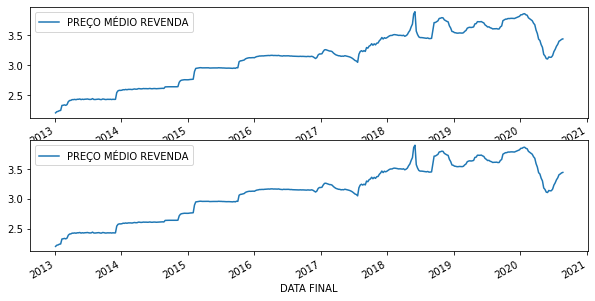

In [113]:
# plotar gráfico semanal e mensal
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,5))
df_treino.plot(ax=ax1)
df_treino.plot(ax=ax2)
plt.show()

In [114]:
# transfromando o dataframe para o formato exigido pelo Prophet
df_treino = df_treino.reset_index().rename(columns={'DATA FINAL':'ds', 'PREÇO MÉDIO REVENDA':'y'})
#df_teste = df_treino.reset_index().rename(columns={'DATA FINAL':'ds', 'PREÇO MÉDIO REVENDA':'y'})[-12:]
df_treino.head()

,ds,y
0,2013-01-05,2.202
1,2013-01-12,2.222
2,2013-01-19,2.227
3,2013-01-26,2.239
4,2013-02-02,2.243


In [129]:
# Instanciar e treinar o modelo
model = Prophet(weekly_seasonality=True,daily_seasonality=True)
# Considerando datas comemorativas brasileiras, a princípio não foi observado mudança na demanda relacionada a feriados no BRASIL
model.add_country_holidays(country_name='BR')
model.fit(df_treino)

# Determinar o período para previsão (usei a frequência semanal para as proximas 52 semanas)
proximos_365d = model.make_future_dataframe(periods=52, freq='W')

# Realizar a previsão para o período estabelecidott
previsao = model.predict(proximos_365d)
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Souls' Day,All Souls' Day_lower,All Souls' Day_upper,Christmas,Christmas_lower,Christmas_upper,Independence Day,Independence Day_lower,Independence Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Our Lady of the Apparition,Our Lady of the Apparition_lower,Our Lady of the Apparition_upper,Republic Proclamation Day,Republic Proclamation Day_lower,Republic Proclamation Day_upper,Tiradentes,Tiradentes_lower,Tiradentes_upper,Worker's Day,Worker's Day_lower,Worker's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
445,2021-07-18,3.290529,3.114527,3.388445,3.231827,3.347029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.035055,-0.035055,-0.035055,0.039147,0.039147,0.039147,0.0,0.0,0.0,-0.004893,-0.004893,-0.004893,-0.069308,-0.069308,-0.069308,0.0,0.0,0.0,3.255474
446,2021-07-25,3.287905,3.130696,3.400703,3.227425,3.346457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.029793,-0.029793,-0.029793,0.039147,0.039147,0.039147,0.0,0.0,0.0,-0.004893,-0.004893,-0.004893,-0.064047,-0.064047,-0.064047,0.0,0.0,0.0,3.258112
447,2021-08-01,3.285282,3.117375,3.404002,3.222978,3.345975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020747,-0.020747,-0.020747,0.039147,0.039147,0.039147,0.0,0.0,0.0,-0.004893,-0.004893,-0.004893,-0.055001,-0.055001,-0.055001,0.0,0.0,0.0,3.264535
448,2021-08-08,3.282658,3.121077,3.413725,3.218316,3.345865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013758,-0.013758,-0.013758,0.039147,0.039147,0.039147,0.0,0.0,0.0,-0.004893,-0.004893,-0.004893,-0.048011,-0.048011,-0.048011,0.0,0.0,0.0,3.268901
449,2021-08-15,3.280035,3.122264,3.395961,3.213992,3.345457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014368,-0.014368,-0.014368,0.039147,0.039147,0.039147,0.0,0.0,0.0,-0.004893,-0.004893,-0.004893,-0.048622,-0.048622,-0.048622,0.0,0.0,0.0,3.265667


# Considerações
Foi observado que houve uma variação consideravelmente grande nos dados históricos nos períodos do primeiro semestre de 2020 forçando um previsão de redução dos preços nos períodos futuros. Isto já havia sido observado no ano anterior (2019) e que se acentuou com a queda do valor do petróleo no inicio de março de 2020. Está variação criou uma alteração de tendência do próprio modelo.

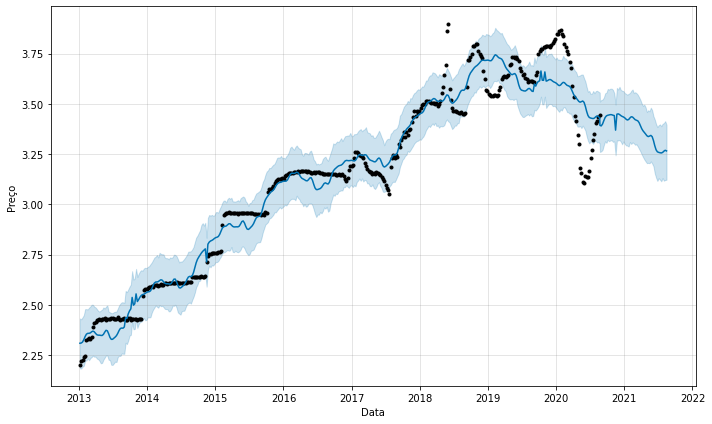

In [130]:
# visualizar o gráfico com as previsões
model.plot(previsao, xlabel='Data', ylabel='Preço');

# Validação e Testes do Modelo
O Prophet possui funções para teste e validação cruzada ***(cross-validation)*** para medir erros com dados históricos. Isto é feito seccionando o conjunto de dados em pedaços para testar o modelo e vomparar com os dados seguintes (que não participaram do modelo). Este processo pode ser feito em linha de código de forma manual, mas para facilitar o processo fizemos uso das ferramentas disponíveis no pacote.
### Abaixo temos alguns modelos de ***Cross-Validation*** inclusive o modelousado pelo ***Prophet***.
<p align="center"><img src="https://github.com/EricoCoutoJr/Previsao-Preco-Diesel-S10/blob/master/time-series-forecasting-cross-validation.jpg?raw=true" height="80%" /img></p>

Neste processo vamos usar a métrica para avaliar a performance do modelo o MAPE ou ***Mean Absolute Percentage Error - MAPE*** ou **Erro Percentual Médio Absoluto**

Vemos por esta previsão que erros em torno de 3% a 5% são típicos para previsões de 50 a 230 dias no futuro, e que os erros aumentam até cerca de 8% para previsões que ocorrerão para 300 no futuro.

INFO:fbprophet:Making 8 forecasts with cutoffs between 2016-02-27 00:00:00 and 2019-08-24 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77ecc0aa58>


   horizon       mse      rmse       mae      mape     mdape  coverage
0  42 days  0.010756  0.103711  0.085002  0.024977  0.024690  0.375000
1  49 days  0.011734  0.108325  0.090618  0.026508  0.027189  0.329268
2  56 days  0.012540  0.111984  0.093347  0.027257  0.027453  0.326220
3  63 days  0.012676  0.112588  0.093621  0.027285  0.027937  0.350610
4  70 days  0.013372  0.115636  0.096273  0.027968  0.028064  0.326220
5  77 days  0.013326  0.115440  0.095865  0.027829  0.028089  0.347561
6  84 days  0.013914  0.117958  0.096405  0.027994  0.027220  0.347561
7  91 days  0.016914  0.130052  0.103047  0.029752  0.027745  0.350610
8  98 days  0.021354  0.146129  0.112987  0.032429  0.028045  0.329268
9 105 days  0.021621  0.147042  0.113520  0.032695  0.027745  0.347561 



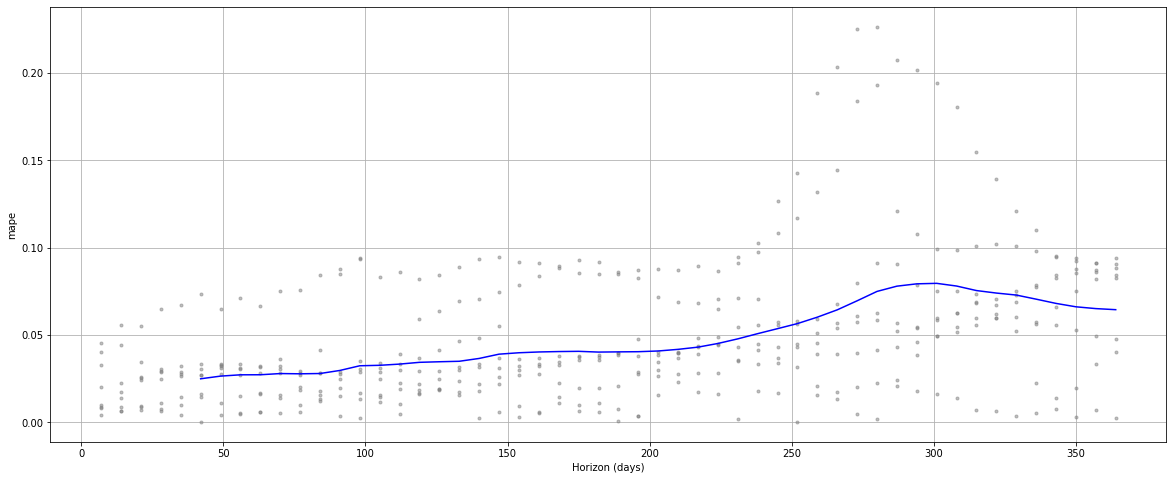

In [131]:
#importando as funções de validação cruzada e medição de performace do modelo
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# nesta validação cruzada foi necessário informar o periodo futuro a ser analizado em semanas (52 semanas)
df_cv = cross_validation(model, horizon = '52 W', parallel='processes')

# nesta linhas iremos medir a performance do modelo (entre o previsto "yhat" e o executado "y")
df_pm = performance_metrics(df_cv)
print(df_pm.head(10), "\n")

plot_cross_validation_metric(df_cv, metric='mape',figsize=(20,8));

# Conclusão
Mesmo considerando que os valores de acurácia estão relativamente bons por um longo período de previsão e já que dados históricos deste ano tiveram amplitude consideravelmete grande, é aconselhado que este modelo seja recosntruido mais uma vez até o fim do ano de 2020.